# Classification

In [1]:
import matplotlib as mplt
import matplotlib.pyplot as plt
import numpy as np

## MNIST

We will be using the MNIST dataset, so let's start by loading it:

In [2]:
from sklearn.datasets import fetch_openml
X, y = fetch_openml('mnist_784', version=1, return_X_y=True)
X, y = X.values.astype(np.uint8), y.values.astype(np.uint8)

Let's show the first 100 digits so we can get a better idea of what we are working with:

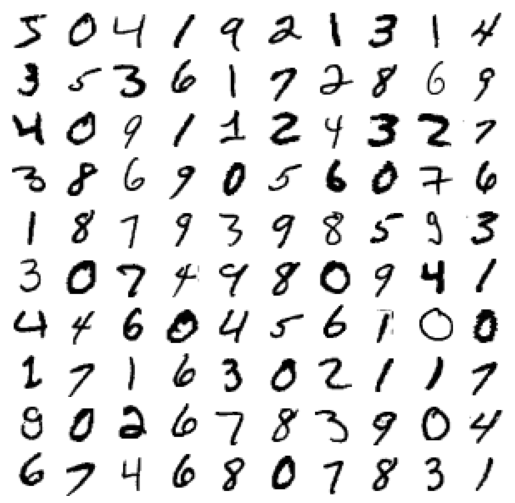

In [3]:
# Show the first 100 instances
some_digits = X[:100]

fig, ax = plt.subplots(10, 10, figsize=(9, 9), subplot_kw=dict(xticks=[], yticks=[]))
fig.subplots_adjust(hspace=0.05, wspace=0.05)

for i, axi in enumerate(ax.flat):
    axi.axis('off')
    im = axi.imshow(X[i].reshape(28, 28), cmap='binary')

The MNIST dataset is already split into a training set (first 60,000) and a test set (last 10,000):

In [4]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

## Training a Binary Classifier

We will transform this classification problem into a binary one: we will split the data into two classes, 5 and not-5:

In [5]:
y_train_5 = (y_train == 5)
y_test_5 = (y_test == 5)

Let's train a _Stochastic Gradient Descent_ (SGD) on this data:

In [6]:
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import cross_val_score

sgd_clf = SGDClassifier(random_state=42)

# 3 fold cross validation to evaluate the accuracy of the model
cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring='accuracy')

array([0.95035, 0.96035, 0.9604 ])

The model got over 90% accuracy! This might sound impressive at first glance, but not so much if we consider the split between 5 and not-5 digits:

In [7]:
np.count_nonzero(y_train_5) / y_train_5.shape[0]

0.09035

The 5 digits represent about 9% of the dataset! This means that a simple classifier that guesses that the digits are never a 5, would get over 90% accuracy! For _skewed datasets_ such as this, the accuracy is not a good metric to measure performance.

## Performance Measures

Let's take a look at the confusion matrix to get a better idea of the model's performance:

In [8]:
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

confusion_matrix(y_train_5, y_train_pred)

array([[53892,   687],
       [ 1891,  3530]])

We can see that the positive class (5) gets confused with the negative class (not-5) quite often! This shows that the model is not that good at distinguishing between both of them as the accuracy would lead us to believe. We can verify this by computing the precision and recall scores:

In [9]:
from sklearn.metrics import precision_score, recall_score

print("Precision score:", precision_score(y_train_5, y_train_pred))
print("Recall score:", recall_score(y_train_5, y_train_pred))

Precision score: 0.8370879772350012
Recall score: 0.6511713705958311


The $F_1$ score is the harmonic mean of precision and recall. Let's see how our model scores:

In [10]:
from sklearn.metrics import f1_score

print("F1 score:", f1_score(y_train_5, y_train_pred))

F1 score: 0.7325171197343846


It doesn't look that great anymore, right?

Another common tool we could use to evaluate this model's performance is the ROC curve! Let's see what it tells us:

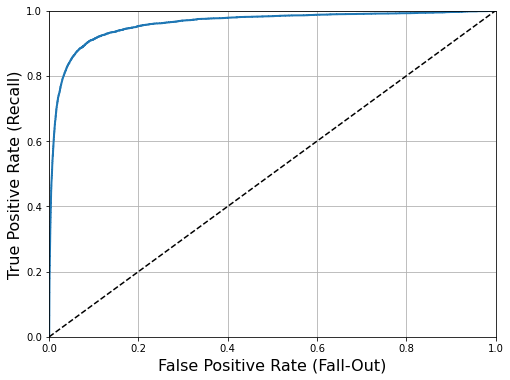

In [11]:
from sklearn.metrics import roc_curve
from sklearn.model_selection import cross_val_predict

def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--') # dashed diagonal
    plt.axis([0, 1, 0, 1])                                    # Not shown in the book
    plt.xlabel('False Positive Rate (Fall-Out)', fontsize=16) # Not shown
    plt.ylabel('True Positive Rate (Recall)', fontsize=16)    # Not shown
    plt.grid(True)   

y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3, method='decision_function')

fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

plt.figure(figsize=(8, 6))
plot_roc_curve(fpr, tpr)

We can measure the _area under the curve_ (AUC) for a quantitative measure:

In [12]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_train_5, y_scores)

0.9604938554008616

We will now train a `RandomForestClassifier` and compare its ROC curve and ROC AUC score to those of the `SGDClassifier`:

In [13]:
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(random_state=42)

y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3, method='predict_proba')

With the model trained, we just need to plot the ROC curves:

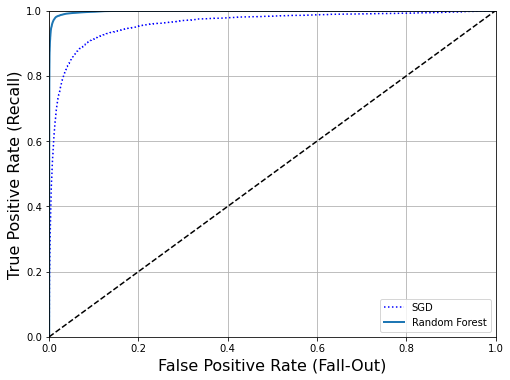

In [14]:
y_scores_forest = y_probas_forest[:, 1]
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5, y_scores_forest)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, 'b:', label="SGD")
plot_roc_curve(fpr_forest, tpr_forest, "Random Forest")
plt.legend(loc="lower right")
plt.show()

We can see that the Random Forest performs much better, as it gets much closer to the perfect spot (upper left corner). Evidently, the ROC AUC score is very high as well:

In [15]:
roc_auc_score(y_train_5, y_scores_forest)

0.9983436731328145

## Multiclass Classification

We can force Scikit-Learn to the use one-versus-one or one-versus-the-rest using the `OneVsOneClassifier` or `OneVsRestClassifier` classes. For example, this is how we would train a SVM using OvR instead of OvO (the default):

In [16]:
from sklearn.svm import SVC
from sklearn.multiclass import OneVsRestClassifier

ovr_clf = OneVsRestClassifier(SVC())
ovr_clf.fit(X_train[:5000], y_train[:5000])
len(ovr_clf.estimators_)

10

# Exercises

## 1.

In [17]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
import sklearn.utils 

knn_clf = KNeighborsClassifier(algorithm='kd_tree')

# Resample training set to make training faster
X_resample, y_resample = sklearn.utils.resample(X_train, y_train, replace=False, n_samples=10000, random_state=42)

# Grid Search
param_grid = [{
    'weights': ['uniform', 'distance'],
    'n_neighbors': list(range(2, 5))
}]

grid_search = GridSearchCV(knn_clf, param_grid, cv=3, n_jobs=-1)

grid_search.fit(X_resample, y_resample)

# Retrain best estimator on full training set
clf = KNeighborsClassifier(algorithm='kd_tree', **grid_search.best_params_, n_jobs=-1).fit(X_train, y_train)

# Evaluate best estimator on test set
clf.score(X_test, y_test)

0.9714

## 2.

In [18]:
from scipy.ndimage import shift

def shift_augmentation(X, y):
    X_new = []
    y_new = []
    
    for x_, y_ in zip(X, y):
        X_new.append(x_)
        for i in [-1, 1]:
            for j in [-1, 1]:
                X_new.append(shift(x_[:, np.newaxis], [i, j]).ravel())
        y_new.extend([y_] * 5)
        
    return np.asarray(X_new), np.asarray(y_new)

# Augment data
X_train, y_train = shift_augmentation(X_train, y_train)

# Shuffle data
perm = np.random.permutation(X_train.shape[0])
X_train = X_train[perm]
y_train = y_train[perm]

# Retrain best estimator on full training set
clf = KNeighborsClassifier(algorithm='kd_tree', **grid_search.best_params_, n_jobs=-1).fit(X_train, y_train)

# Evaluate best estimator on test set
clf.score(X_test, y_test)

0.9714

## 3.

These exercise is a bit laborious compared to the previous one, so we'll use multiple cells here to keep it organized. We need to tackle the Titanic dataset, so we'll start by cleaning up the workspace and loading the new data:

In [19]:
# Clear workspace
%reset -f

import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_openml

titanic = fetch_openml('Titanic', version=1)

In [20]:
X, y = titanic['data'], titanic['target']
X.head()

,pclass,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,boat,body,home.dest
0,1.0,"Allen, Miss. Elisabeth Walton",female,29.0000,0.0,0.0,24160,211.3375,B5,S,2,NaN,"St Louis, MO"
1,1.0,"Allison, Master. Hudson Trevor",male,0.9167,1.0,2.0,113781,151.5500,C22 C26,S,11,NaN,"Montreal, PQ / Chesterville, ON"
2,1.0,"Allison, Miss. Helen Loraine",female,2.0000,1.0,2.0,113781,151.5500,C22 C26,S,None,NaN,"Montreal, PQ / Chesterville, ON"
3,1.0,"Allison, Mr. Hudson Joshua Creighton",male,30.0000,1.0,2.0,113781,151.5500,C22 C26,S,None,135.0,"Montreal, PQ / Chesterville, ON"
4,1.0,"Allison, Mrs. Hudson J C (Bessie Waldo Daniels)",female,25.0000,1.0,2.0,113781,151.5500,C22 C26,S,None,NaN,"Montreal, PQ / Chesterville, ON"


We can see that we need to predict whether or not a given person survived:

In [21]:
y.head()

0    1
1    1
2    0
3    0
4    0
Name: survived, dtype: category
Categories (2, object): ['0', '1']

The approach will be similar to that used in the previous chapter. We will split the data into a training and testing set before further inspections:

In [22]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1047 entries, 371 to 1027
Data columns (total 13 columns):
 #   Column     Non-Null Count  Dtype   
---  ------     --------------  -----   
 0   pclass     1047 non-null   float64 
 1   name       1047 non-null   object  
 2   sex        1047 non-null   category
 3   age        842 non-null    float64 
 4   sibsp      1047 non-null   float64 
 5   parch      1047 non-null   float64 
 6   ticket     1047 non-null   object  
 7   fare       1046 non-null   float64 
 8   cabin      237 non-null    object  
 9   embarked   1045 non-null   category
 10  boat       387 non-null    object  
 11  body       101 non-null    float64 
 12  home.dest  606 non-null    object  
dtypes: category(2), float64(6), object(5)
memory usage: 100.5+ KB


We can see that there is a lot of data missing. In fact, there are attributes with more instances of missing data than instances with the field filled! On top of that, there are some attributes that are not that interesting to us right now, such as passenger names. With this in mind, we'll create a custom transformer to help us select attributes that we are interested in:

In [23]:
from sklearn.base import BaseEstimator, TransformerMixin

class DataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_names):
        self.attribute_names = attribute_names
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        return X[self.attribute_names]

Now we can begin creating our preprocessing pipelines. We'll handle numerical and categorical attributes separately:

In [24]:
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

num_pipeline = Pipeline([
    ('select_numeric', DataFrameSelector(['age', 'sibsp', 'parch', 'fare'])),
    ('imputer', SimpleImputer(strategy='median'))
])

num_pipeline.fit_transform(X_train)

array([[45.    ,  0.    ,  2.    , 30.    ],
       [16.    ,  0.    ,  0.    ,  7.65  ],
       [ 5.    ,  4.    ,  2.    , 31.3875],
       ...,
       [39.    ,  0.    ,  0.    , 13.    ],
       [35.    ,  1.    ,  1.    , 20.25  ],
       [28.    ,  0.    ,  0.    ,  8.05  ]])

In [25]:
from sklearn.preprocessing import OneHotEncoder

cat_pipeline = Pipeline([
    ('select_cat', DataFrameSelector(['pclass', 'sex', 'embarked'])),
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('cat_encoder', OneHotEncoder(sparse=False))
])

cat_pipeline.fit_transform(X_train)

array([[0., 1., 0., ..., 0., 0., 1.],
       [0., 0., 1., ..., 0., 0., 1.],
       [0., 0., 1., ..., 0., 0., 1.],
       ...,
       [0., 1., 0., ..., 0., 0., 1.],
       [0., 0., 1., ..., 0., 0., 1.],
       [0., 0., 1., ..., 0., 0., 1.]])

These two pipelines can be combined into one that will do all the heavy-lifting for us:

In [26]:
from sklearn.pipeline import FeatureUnion

preprocess_pipeline = FeatureUnion(transformer_list=[
    ('num_pipeline', num_pipeline),
    ('cat_pipeline', cat_pipeline)
])

With the pipeline ready, we can simply apply it to the data:

In [27]:
X_train = preprocess_pipeline.fit_transform(X_train)
X_train

array([[45.,  0.,  2., ...,  0.,  0.,  1.],
       [16.,  0.,  0., ...,  0.,  0.,  1.],
       [ 5.,  4.,  2., ...,  0.,  0.,  1.],
       ...,
       [39.,  0.,  0., ...,  0.,  0.,  1.],
       [35.,  1.,  1., ...,  0.,  0.,  1.],
       [28.,  0.,  0., ...,  0.,  0.,  1.]])

We'll now feed the preprocessed data to a `RandomForestClassifier` model:

In [28]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score

clf = RandomForestClassifier(n_estimators=150, n_jobs=-1)
forest_scores = cross_val_score(clf, X_train, y_train, cv=10)
forest_scores.mean()

0.7803937728937729

This gives us roughly 80% accuracy on the training data with cross-validation! It's not an astounding result, but it is definitely not terrible. We could further improve this result by doing more feature engineering and comparing and tuning more models.

## 4.

**TODO**